# JPEG encoding 

- 이 파일은 JPEG Encoding만 담은 코드입니다. 
- Decoding은 JPEG.py에 전체 코드가 있으며 Encoding의 역순이라 따로 담지 않았습니다

## Image load + module import

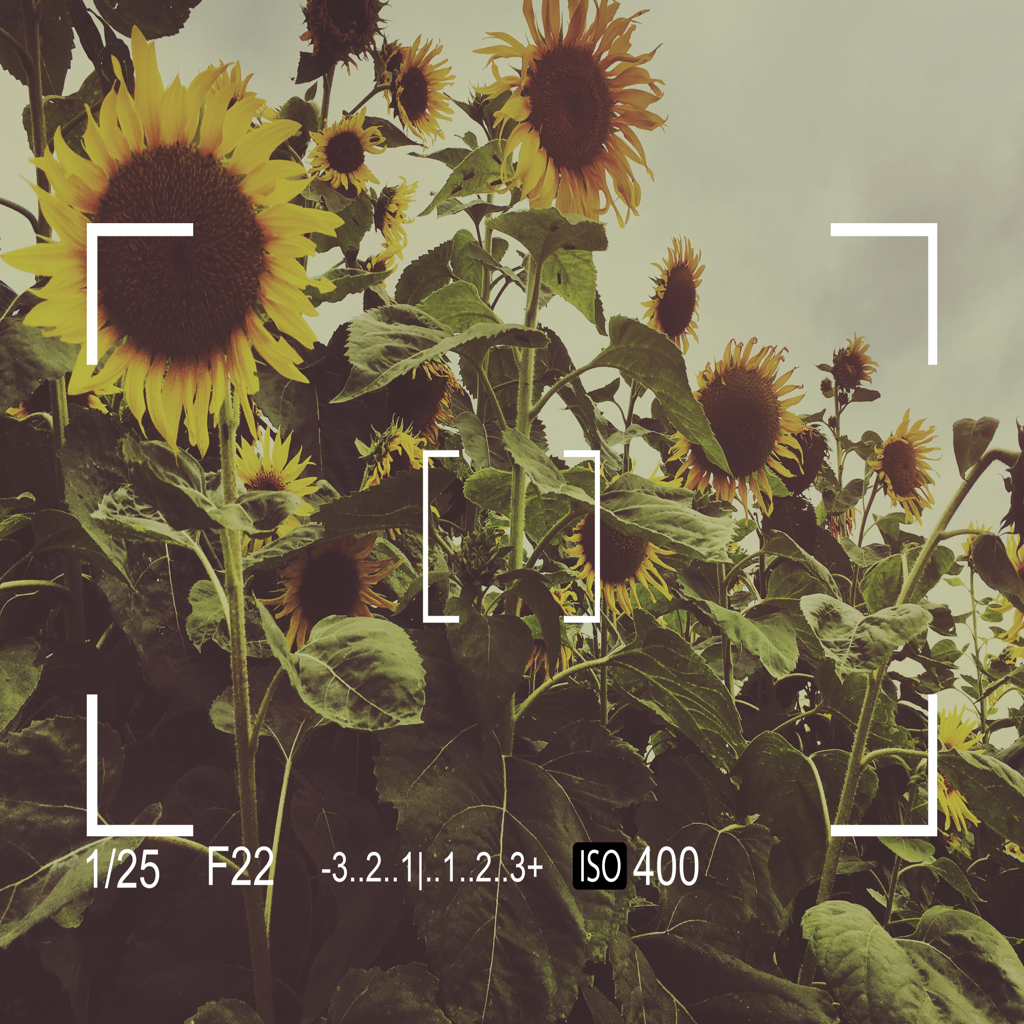

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct
img = Image.open("./10242.jpg")
img = img.resize((1024,1024))
img.size
img

## RGB -> YCbCr 변환 + 시각화 

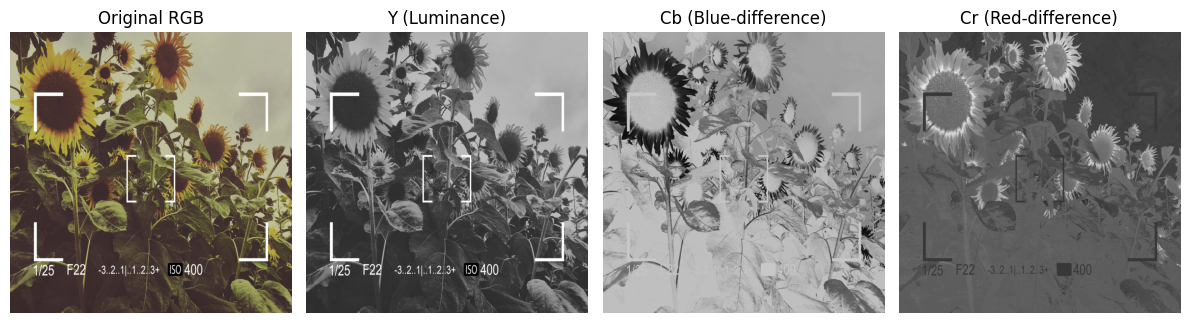

In [17]:
ycbcr_img = img.convert("YCbCr")
Y, Cb, Cr = ycbcr_img.split()
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].imshow(img)
axes[0].set_title("Original RGB")
axes[0].axis("off")

axes[1].imshow(Y, cmap="gray")
axes[1].set_title("Y (Luminance)")
axes[1].axis("off")

axes[2].imshow(Cb, cmap="gray")
axes[2].set_title("Cb (Blue-difference)")
axes[2].axis("off")

axes[3].imshow(Cr, cmap="gray")
axes[3].set_title("Cr (Red-difference)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

## Cb,Cr downsampling 
- Y channel : (512,512)
- Cb,Cr channel : (256,256)

Original Y shape: (1024, 1024)
Downsampled Cb/Cr shape: (512, 512)


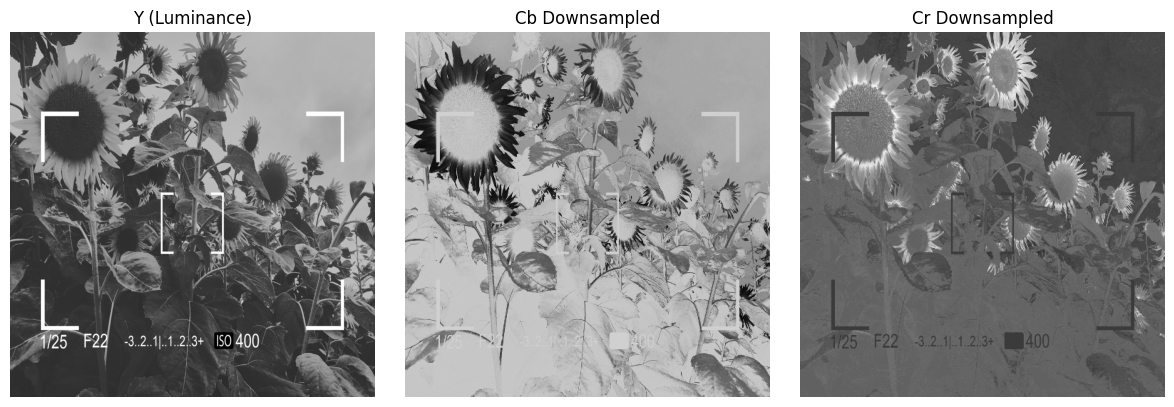

In [18]:
Y = np.array(Y,dtype = np.float32)
Cb = np.array(Cb,dtype = np.float32)
Cr = np.array(Cr,dtype = np.float32)

Cb = Cb[::2,::2] #downsampling
Cr = Cr[::2,::2] #downsampling

print("Original Y shape:", Y.shape)
print("Downsampled Cb/Cr shape:", Cb.shape)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(Y, cmap="gray")
axes[0].set_title("Y (Luminance)")
axes[0].axis("off")

axes[1].imshow(Cb, cmap="gray")
axes[1].set_title("Cb Downsampled")
axes[1].axis("off")

axes[2].imshow(Cr, cmap="gray")
axes[2].set_title("Cr Downsampled")
axes[2].axis("off")

plt.tight_layout()
plt.show()

    

## DCT 변환
- 원본 이미지 8x8 분할 후 각 패치를 DCT변환
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html 에서 해당 함수 확인가능
- dct함수는 1D로 진행하기 때문에 두번 감쌈
- type=2는 JPEG표준 연산식
- DCT의 기본정의는 정규화가 안됐기 때문에 "ortho"로 직교 정규화를 해야 나중에 idct를 완전히 복원가능
- https://www.thewebmaster.com/jpeg-definitive-guide/ 양자화 테이블 확인가능
- 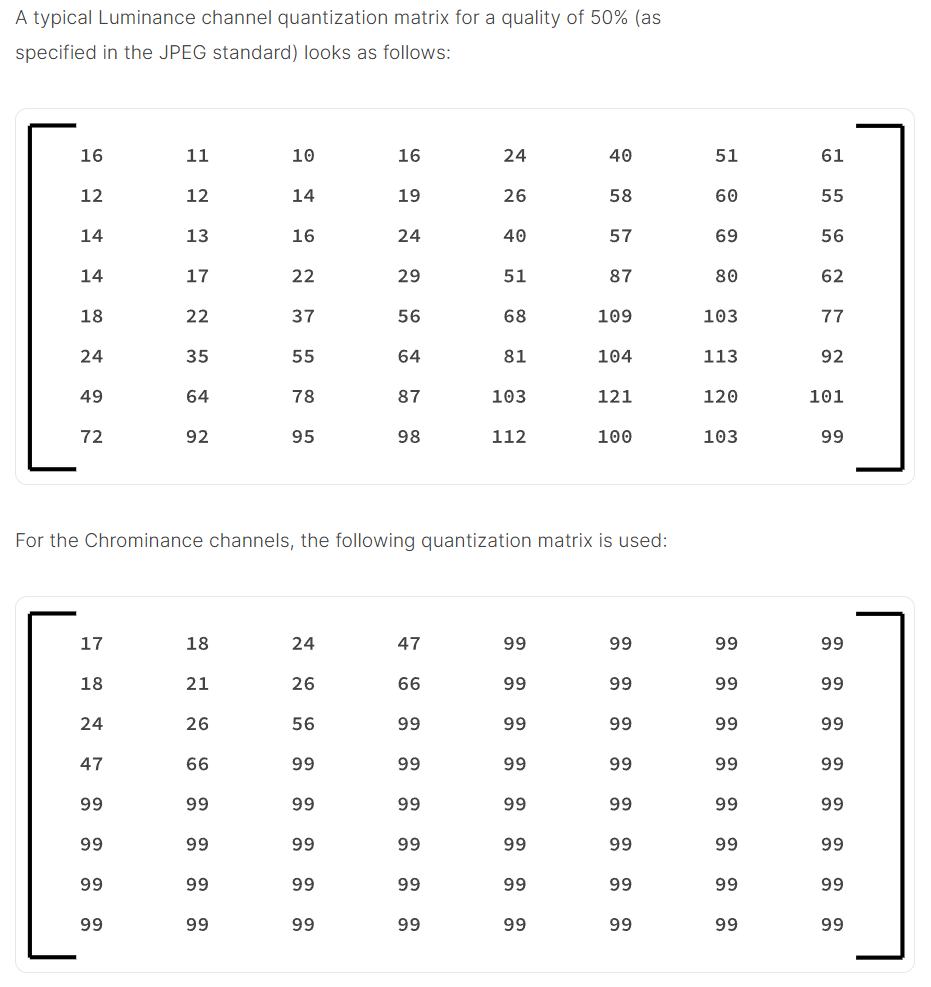

In [19]:
QY = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])
QC = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99]
])
def DCT(block):
    return dct(dct(block,type=2,norm="ortho").T,type=2,norm="ortho")

def IDCT(block):    
    return idct(idct(block,type=2,norm="ortho").T,type=2,norm="ortho")

def process_img(image,Q):
    """image를 8x8 패치로 잘라서 DCT변환합니다."""
    h,w = image.shape #(512,512)
    channel_dctq = np.zeros((h,w),dtype = np.float32) #같은 크기만큼 0으로 채워넣기
    for i in range(0,h,8): 
        for j in range(0,w,8):
            block = image[i:i+8,j:j+8] - 128
            dct_block = DCT(block)
            q_block = np.round(dct_block/Q)
            channel_dctq[i:i+8,j:j+8] = q_block
    return channel_dctq


Y_dctq = process_img(Y,QY)
Cb_dctq = process_img(Cb,QC)
Cr_dctq = process_img(Cr,QC)

print("Original Y shape:", Y.shape)
print("DCT Y shape:", Y_dctq.shape)

print("Original Cb shape:", Cb.shape)
print("DCT Cb shape:", Cb_dctq.shape)

print("Original Cr shape:", Cr.shape)
print("DCT Cr shape:", Cr_dctq.shape)

Original Y shape: (1024, 1024)
DCT Y shape: (1024, 1024)
Original Cb shape: (512, 512)
DCT Cb shape: (512, 512)
Original Cr shape: (512, 512)
DCT Cr shape: (512, 512)


## Run-Length Encoding
- 8x8 패치로 나눠서 지그재그 인덱스를 만든 뒤, 중복되는 문자를 한 문자로 치환하는 압축 방식

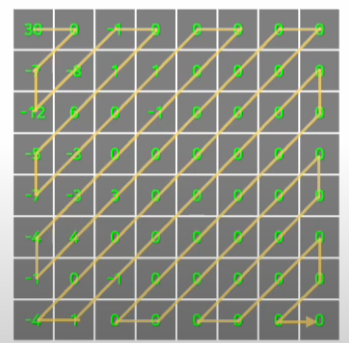


In [25]:
def zigzag_indices(n=8):
    """8x8 인덱스 설정"""
    indices = []
    for s in range(2*n - 1):
        if s % 2 == 0:
            for i in range(s+1):
                j = s - i
                if i < n and j < n:
                    indices.append((i, j))
        else:
            for i in range(s, -1, -1):
                j = s - i
                if i < n and j < n:
                    indices.append((i, j))
    return indices

zigzag_index = zigzag_indices(8)
print(zigzag_index)

def zigzag_scan(block):
    """8x8패치를 한줄로 펼치기"""
    return [block[i,j] for i,j in zigzag_index]
print(len(zigzag_scan(Y_dctq[0:8,0:8])))

def RLE(coeffs):
    """Run Length Encoding"""
    result = []
    zeros = 0
    for c in coeffs[1:]:
        if c==0:
            zeros+=1
        else:
            result.append((zeros,int(c)))
            zeros=0
    result.append((0,0))
    return [coeffs[0]] + result

def jpeg_encode(channel):
    h,w = channel.shape
    encoded_blocks=[]
    for i in range(0,h,8):
        for j in range(0,w,8):
            block = channel[i:i+8,j:j+8]
            coeffs = zigzag_scan(block)
            rle = RLE(coeffs)
            encoded_blocks.append(rle)
    return encoded_blocks 
Y_encoded = jpeg_encode(Y_dctq) 
Cb_encoded = jpeg_encode(Cb_dctq)
Cr_encoded = jpeg_encode(Cr_dctq)
print(Y_encoded[10000])
print(len(Cb_encoded))
print(len(Cr_encoded))



[(0, 0), (1, 0), (0, 1), (0, 2), (1, 1), (2, 0), (3, 0), (2, 1), (1, 2), (0, 3), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0), (5, 0), (4, 1), (3, 2), (2, 3), (1, 4), (0, 5), (0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0), (7, 0), (6, 1), (5, 2), (4, 3), (3, 4), (2, 5), (1, 6), (0, 7), (1, 7), (2, 6), (3, 5), (4, 4), (5, 3), (6, 2), (7, 1), (7, 2), (6, 3), (5, 4), (4, 5), (3, 6), (2, 7), (3, 7), (4, 6), (5, 5), (6, 4), (7, 3), (7, 4), (6, 5), (5, 6), (4, 7), (5, 7), (6, 6), (7, 5), (7, 6), (6, 7), (7, 7)]
64
[np.float32(-30.0), (0, 2), (0, -1), (0, 1), (0, -3), (0, 1), (6, 1), (0, 0)]
4096
4096


## hufman 


In [7]:
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_table):
    """빈도 테이블을 기반으로 Huffman 트리 구축"""
    heap = []
    for symbol, freq in freq_table.items():
        heapq.heappush(heap, HuffmanNode(symbol, freq))
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        parent = HuffmanNode(None, left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(heap, parent)
    
    return heap[0]

def generate_huffman_codes(node, current_code="", codes=None):
    """Huffman 트리에서 코드 생성"""
    if codes is None:
        codes = {}
    
    if node.symbol is not None:
        codes[node.symbol] = current_code or "0"
    
    if node.left:
        generate_huffman_codes(node.left, current_code + "0", codes)
    if node.right:
        generate_huffman_codes(node.right, current_code + "1", codes)
    
    return codes

def huffman_encode(rle_data):
    """RLE 데이터를 Huffman 코딩으로 압축"""
    dc_coeffs = [block[0] for block in rle_data]
    ac_coeffs = [tuple(item) for block in rle_data for item in block[1:]]
    
    dc_freq = Counter(dc_coeffs)
    ac_freq = Counter(ac_coeffs)
    
    dc_tree = build_huffman_tree(dc_freq)
    ac_tree = build_huffman_tree(ac_freq)
    dc_codes = generate_huffman_codes(dc_tree)
    ac_codes = generate_huffman_codes(ac_tree)
    
    bitstream = bitstring.BitArray()
    for block in rle_data:
        bitstream.append(f"0b{dc_codes[block[0]]}")
        for ac in block[1:]:
            bitstream.append(f"0b{ac_codes[tuple(ac)]}")
    
    return bitstream, dc_codes, ac_codes

## 